
I am a big Jeopardy! fan and when I found out about the [Jeopardy! data set](https://data.world/sya/200000-jeopardy-questions), I had to play around with it. After taking a look, I decided to see if I could, in a small way, replicate the famous quiz-playing machine [Watson developed by IBM](https://en.wikipedia.org/wiki/Watson_(computer).

For this blog post, I'll investigate how well I can build a simple classifier to answer Jeopardy! questions about states in the U.S. I'll use previous Jeopardy! answers and questions to train my model. 

## Let's get started!


![Jeopardy!](./images/jeopardy.gif)


# Step #1: Setup and Import Packages

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# set up display properties
%matplotlib inline
# this is a pretty wide data set, i.e., it has lot's of columns, so I'll use this command to set the display wider.
pd.set_option('max_colwidth', 300)  
# packages used in modeling
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">A data scientist&#39;s &quot;Hello, World&quot;:<br><br>import numpy as np<br>import pandas as pd<br><br>print(&quot;Hello, World!&quot;)</p>&mdash; David Asboth (@davidasboth) <a href="https://twitter.com/davidasboth/status/778951814301552641?ref_src=twsrc%5Etfw">September 22, 2016</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


# Step #2: Read in data and explore a little

In [2]:
df = pd.read_csv('JEOPARDY_CSV.csv')

In [3]:
# how big is the data set
df.shape

(216930, 7)

In [4]:
# take a look at the first few rows of the dataframe
df.head()

,Show_Number,Air_Date,Round,Category,Value,Question,Answer
0,4680,12/31/04,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus
1,4680,12/31/04,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe
2,4680,12/31/04,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
3,4680,12/31/04,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's
4,4680,12/31/04,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams


## Side note:
So, Jeopardy! is a bit unusual in its naming of answers and questions, e.g., I just said "answers and questions" instead of "questions and answers."  Jeopardy! requires contestants to state their responses in the form of a question. For example, for row 0 shown above, Alex Trebek (the game show host) would say, "Answer: For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory".  Then a contestant would have to answer with "Who is Copernicus?" in order to be awarded \$200. If they instead said "Copernicus," then they the buzzer would sound and they would lose \$200. For sanity-sake, I'll reverse the standard Jeopardy! naming and use the column names shown in the dataframe above.

In [5]:
# what are the most common Jeopardy! answers?
df['Answer'].value_counts().head()

China        216
Australia    215
Japan        196
Chicago      194
France       193
Name: Answer, dtype: int64

In [6]:
# what about for the Jeopardy! vs Double Jeopardy! rounds?
df[df['Round']=='Jeopardy!']['Answer'].value_counts().head()

China         117
California    115
Chicago       114
Australia     109
Japan         106
Name: Answer, dtype: int64

In [7]:
# what about for the Jeopardy! vs Double Jeopardy! rounds?
df[df['Round']=='Double Jeopardy!']['Answer'].value_counts().head()

Australia    102
China         95
India         93
Paris         89
Mexico        89
Name: Answer, dtype: int64

# Step #3: Build dataframe of only U.S. states

Geography is big in Jeopardy! in both rounds. Let's select only answers that are U.S. states.


![Map_of_USA_with_state_names_2](./images/Map_of_USA_with_state_names_2.svg)
CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=8884010

In [8]:
# build list of U.S. states
state_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 
              'Colorado', 'Connecticut', 'Delaware', 'Florida', 
              'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
              'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 
              'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
              'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 
              'New Jersey', 'New Mexico', 'New York', 'North Carolina', 
              'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 
              'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 
              'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
              'West Virginia', 'Wisconsin', 'Wyoming']
# verify the length is 50
len(state_list)

50

In [9]:
# create dataset that contains only answers from state_list.
df_states = df[df['Answer'].isin(state_list)].copy(deep= True)
# check the size
df_states.shape

(3893, 7)

Our original data set had about 200,000 rows and selecting only rows where the answer is a U.S. state drops it down to almost 4,000. Let's explore this data set a bit.

In [10]:
# what does the data look like?
df_states.head()

,Show_Number,Air_Date,Round,Category,Value,Question,Answer
2,4680,12/31/04,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
8,4680,12/31/04,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$400,"In the winter of 1971-72, a record 1,122 inches of snow fell at Rainier Paradise Ranger Station in this state",Washington
95,5957,7/6/10,Double Jeopardy!,SEE & SAY,$800,"Say <a href=""http://www.j-archive.com/media/2010-07-06_DJ_27.jpg"" target=""_blank"">this</a> state that was admitted to the Union in 1859",Oregon
108,5957,7/6/10,Double Jeopardy!,NEWS TO ME,"$1,600","In a surprise, Ted Kennedy's old Senate seat in this state went to a Republican in a January 2010 election",Massachusetts
299,5690,5/8/09,Jeopardy!,A STATE OF COLLEGE-NESS,$200,"Baylor, Stephen F. Austin, Rice",Texas


In [11]:
# what are the most popular answers about U.S. states?
df_states['Answer'].value_counts().head()

California    180
Alaska        161
Hawaii        157
Texas         153
Florida       140
Name: Answer, dtype: int64

In [12]:
# what percentage of questions are about the top states?
df_states['Answer'].value_counts(normalize = True).head() *100

California    4.623684
Alaska        4.135628
Hawaii        4.032880
Texas         3.930131
Florida       3.596198
Name: Answer, dtype: float64

The top three answers appear 4% of the time. If the states were uniformly sampled, then they should all appear about 2% of the time (1/50 X 100%). So California, Alaska, and Hawaii are over-sampled in the Jeopardy! clues.

The goal of my exploration is to build a model that can correctly predict the correct answer to a Jeopardy! question. I'm going to simplify this a bit more because there are 50 states and that's a lot to work with at once. So, I'll focus on only a few states, the top 3, *California, Alaska, and Hawaii*, and then three of the states where I've lived, *Arizona, Washington, and Texas*. Let's see where Washington and Arizona rank in popularity.

In [13]:
df_states['Answer'].value_counts(normalize = True)['Arizona'] *100

2.003596198304649

In [14]:
df_states['Answer'].value_counts(normalize = True)['Washington']*100

2.440277421012073

In [15]:
# build a dataframe with only 6 states
states_6 = ['California', 'Alaska', 'Hawaii', 'Arizona', 'Washington', 'Texas']
df_states_6 = df_states[df_states['Answer'].isin(states_6)].copy(deep= True)
# check the size
df_states_6.shape

(824, 7)

In [16]:
# take a look 
df_states_6.head()

,Show_Number,Air_Date,Round,Category,Value,Question,Answer
2,4680,12/31/04,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
8,4680,12/31/04,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$400,"In the winter of 1971-72, a record 1,122 inches of snow fell at Rainier Paradise Ranger Station in this state",Washington
299,5690,5/8/09,Jeopardy!,A STATE OF COLLEGE-NESS,$200,"Baylor, Stephen F. Austin, Rice",Texas
368,2825,12/6/96,Jeopardy!,ANNUAL EVENTS,$200,"Monroe, near Snohomish in this state, is the site of the annual Evergreen State Fair",Washington
477,5243,5/30/07,Jeopardy!,STATE SUPERLATIVES,$200,A valley at 282 feet below sea level in this state is the lowest point in the Western Hemisphere,California


In [17]:
# 10 questions about Washington
df_states_6[df_states_6['Answer']=='Washington'].head(10)

,Show_Number,Air_Date,Round,Category,Value,Question,Answer
8,4680,12/31/04,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$400,"In the winter of 1971-72, a record 1,122 inches of snow fell at Rainier Paradise Ranger Station in this state",Washington
368,2825,12/6/96,Jeopardy!,ANNUAL EVENTS,$200,"Monroe, near Snohomish in this state, is the site of the annual Evergreen State Fair",Washington
501,5243,5/30/07,Jeopardy!,STATE SUPERLATIVES,"$1,000",Its Boeing manufacturing plant in Everett is the world's largest building by volume,Washington
3088,4487,2/24/04,Double Jeopardy!,THE PRODUCERS,"$1,600",It leads the states in apple production,Washington
3250,5084,10/19/06,Jeopardy!,AMERICAN COUNTIES,"$1,000","While many states have counties named Lincoln, this is the only state that has one named Snohomish",Washington
5099,4842,10/4/05,Jeopardy!,YOUNG ABE LINCOLN,$400,"Among the books read by Lincoln as a youngster were ""Robinson Crusoe"", ""Aesop's Fables"", & Mason Weems' ""Life of"" this man",Washington
6787,4306,4/28/03,Double Jeopardy!,STATE: THE OBVIOUS,$800,Florida's in the southeast corner of the 48 contiguous states; this state is in the northwest corner,Washington
9033,3409,6/3/99,Jeopardy!,BILL GATES' 50 BILLION,$200,"In this state where he lives, Bill could pay the governor's salary for 413,000 years",Washington
11369,5279,7/19/07,Jeopardy!,"WASHINGTON, LINCOLN OR GEORGE W. BUSH",$200,Was born a British subject,Washington
12308,6230,10/21/11,Jeopardy!,STATE OF THE NOVEL,$200,"""Twilight""",Washington


### Washington: State or President?
Taking a look at questions where "Washington" is the answer, shows that the question could be referring to Washington, the state, or Washington, the president. This is something that might play a role in how accurate our model can be with questions about Washington versus questions about Arizona. 

# Step 4: Feature Engineering

Now that we've decided that we want to predict the correct state name given a question, we have to figure out what sort of features a question has that can inform us about how to pick the correct answer. What patterns emerge for each state? Looking at the previous output showing the clues about Washington, a common word that appears is "Snohomish." Does this word appear in questions about any of the other states?

In [18]:
df_states_6[df_states_6['Question'].str.contains("Snohomish")].head(10)

,Show_Number,Air_Date,Round,Category,Value,Question,Answer
368,2825,12/6/96,Jeopardy!,ANNUAL EVENTS,$200,"Monroe, near Snohomish in this state, is the site of the annual Evergreen State Fair",Washington
3250,5084,10/19/06,Jeopardy!,AMERICAN COUNTIES,"$1,000","While many states have counties named Lincoln, this is the only state that has one named Snohomish",Washington


Nope, the only two questions containing the word "Snohomish" have "Washington" as their answer. What about "Evergreen"? After all, Washington is the "Evergreen State."

In [19]:
df_states_6[df_states_6['Question'].str.contains("Evergreen")].head(10)

,Show_Number,Air_Date,Round,Category,Value,Question,Answer
368,2825,12/6/96,Jeopardy!,ANNUAL EVENTS,$200,"Monroe, near Snohomish in this state, is the site of the annual Evergreen State Fair",Washington
106424,3345,3/5/99,Double Jeopardy!,STATE LICENSE PLATES,$800,301-JRJ Evergreen State,Washington
108152,3631,5/22/00,Jeopardy!,ASIAN-AMERICAN ACHIEVERS,$100,"Gary Locke of this ""Evergreen State"" is the first Chinese-American governor in U.S. history",Washington
164029,5122,12/12/06,Jeopardy!,STATE THE STATE,$600,"Shots like the one seen <a href=""http://www.j-archive.com/media/2006-12-12_J_13.jpg"" target=""_blank"">here</a> show you why it's the Evergreen State",Washington


Yes! *Evergreen* is a great indicator that a question is about the state of Washington. 

Using this technique of finding words that are popular in questions about specific states, we will build a model that counts words contained in the questions for each state and use that to predict the answer when we present the model with a never-before-seen question. The test of the model is to see how well the accuracy is on questions where *we* know the answer, but the model doesn't. We will *train* the model on 80% of the data and then *test* it by asking it to predict the answer on the remaining 20%.

In [20]:
# transform dataframe columns containing question and answers to a list
list_docs = df_states_6['Question'].tolist()
list_labels = df_states_6['Answer'].tolist()
# split the data into a training and test set. 
X_train, X_test, y_train, y_test = train_test_split(list_docs, list_labels, test_size = 0.2, random_state = 42)

# Step #5: Building the model

Now, I haven't yet counted all the words in my data set; I'm going to do this at the same time as I build my model. Python's [sk-learn package](http://scikit-learn.org/) has a really great tool called Pipeline. It lets you pass your data through a pipeline of feature engineering and modeling all in one-step. Here, I'll build a pipeline that uses the CountVectorizer package and then passes the data to a logistic regression model. 

In [21]:
# build the pipeline
pipeline_LR = Pipeline([('vect', CountVectorizer(decode_error='ignore')), ('clf', LogisticRegression())])
# pass the data to the pipeline and build a model using the training data set
pipeline_LR = pipeline_LR.fit(X_train, y_train)
# pass the test data to the pipeline and get the predicted values
y_test_predicted = pipeline_LR.predict(X_test)
# calculate the accuracy of the model using the test data and the predicted value of the test data
accuracy = accuracy_score(y_test, y_test_predicted)
accuracy

0.5818181818181818

Hmmm... the accuracy of the model is 58%. Is that good or is that bad? Well, I'm trying to predict the answer to a question where there are 6 possible answers (*California, Alaska, Hawaii, Arizona, Washington, or Texas*). If I were to guess randomly, I would be correct 1/6th of the time or ~17% of the time. So, an accuracy of 58% is actually predict good. It's 3 times better than randomly guessing. 

Now there's a lot more that I could do with improving the model. I can try a few other classification models, like decision trees or support-vector classifier. I could also adjust the default parameters of the model or clean up my data a bit more by removing stop words and punctuation. For now, I'm pretty happy with an accuracy that is better than random.

# Step #6: Investigating the model

Where did the model do well and where did it perform poorly? A confusion matrix is a great visual representation of the answer to this question. A good-looking confusion matrix will have a strongly defined diagonal line. When the true label is *California*, then most of the predicted labels should fall under *California* as well. 

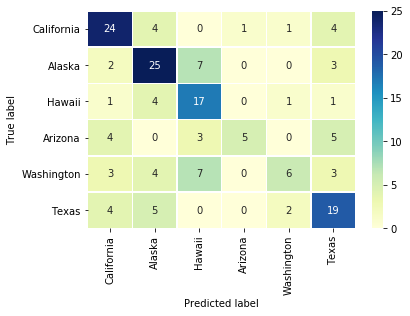

In [22]:
CM = confusion_matrix(y_test, list(y_test_predicted),labels = states_6)
ax = sns.heatmap(CM, linewidths=.5,  xticklabels = states_6, yticklabels = states_6, cmap="YlGnBu", annot = True, fmt = "d")
plt.ylabel('True label')
plt.xlabel('Predicted label');

I had a theory that Washington might be tricky to get right because of possible confusion with the president. It looks like I might be right. 

Both the states of Arizona and Washington were present in the data set by about the same amount. However, in the test data set, Washington is correctly predicted 6 out of 23 times (i. e., 26% of the time) and Arizona is correctly predicted at a slightly higher rate (5/17 or 29%). Let's take a look at some of the cases where Washington is correctly predicted.

In [23]:
# build data frame containing test questions, answers, and predicted answers.
df_states_6_test = pd.DataFrame(
    data = {"Question":X_test,"Answer_true": y_test,"Answer_predicted": list(y_test_predicted)})
# correctly predicting Washington
df_states_6_test[(df_states_6_test['Answer_true']=='Washington') & 
                        (df_states_6_test['Answer_predicted']=='Washington') ]

,Answer_predicted,Answer_true,Question
58,Washington,Washington,"Joseph J. Ellis' biography of this 18th century man is called ""His Excellency"""
84,Washington,Washington,"Gary Locke of this ""Evergreen State"" is the first Chinese-American governor in U.S. history"
104,Washington,Washington,"Title destination of Mr. Smith, Billy Jack & The Happy Hooker"
124,Washington,Washington,His widow Martha once gave the O.K. for him to be re-entombed in the U.S. Capitol; a nephew later nixed the idea
135,Washington,Washington,Edmund Randolph helped draft & ratify the Constitution before becoming this man's Attorney General
140,Washington,Washington,SAW NOTHING


About half of the questions where Washington is the answer have to do with the president and not the state (#58, #124, #135). It  looks like the algorithm is able to pull out information about Washington, whether or not the question is asking about the state or the president.

# Conclusion

I hope you enjoyed this post and you are inspired to learn more about natural language processing and classification problems. Some of the inspiration for this post came from [this notebook by Emmanuel Ameisen](https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb). Also you can learn more about pipelines from [Python Data Science Handbook by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html#Feature-Pipelines).

![clapping.gif](./images/clapping.gif)